<a href="https://colab.research.google.com/github/mcbhavana27/ITS/blob/main/nas_Conv_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from glob import glob
from keras.models import Sequential,Model
import tensorflow as tf
from keras.metrics import MeanSquaredError as mae
from keras import layers
from keras.layers import LSTM,Dense,Dropout,Conv1D,TimeDistributed,Input,Flatten,RepeatVector,Bidirectional,Concatenate,SeparableConv1D,DepthwiseConv1D
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from math import sqrt
#from bokeh.plotting import figure,output_file, show
import datetime

#from openpyxl import Workbook,load_workbook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp  /content/drive/My\ Drive/DATA.zip /content/
!unzip DATA.zip

In [ ]:
Data_file1= glob('DATA/402214'+'/*.csv')
Data_file2= glob('DATA/402510'+'/*.csv')
Data_file3= glob('DATA/402835'+'/*.csv')
Data_file4= glob('DATA/414025'+'/*.csv')

In [ ]:
def data(files,col):
    data=[]
    for file in files:
          data.append(pd.read_csv(file))
    full_data =pd.concat(data,ignore_index=True)
    cols=list(full_data)[col]
    data_set=full_data[cols].astype(str)
    data_set = np.array(data_set)
    print(len(files),len(data_set))
    return data_set

In [ ]:
Data1 = data(Data_file1,2)
Data2 = data(Data_file2,2)
Data3 = data(Data_file3,2)
Data4 = data(Data_file4,2)

13 26193
13 26191
13 26192
13 26192


In [ ]:
print(Data1[-5:])

['36' '35' '33' '32' '30']


In [ ]:
Data1.shape

(26193,)

In [ ]:
data1 = Data1.reshape(Data1.shape[0],1)
scaler1 =MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler1.fit_transform(data1)

In [ ]:
data1.shape

(26193, 1)

In [ ]:
data1a = np.array(data1)
np.save('data1.npy',np.array(data1),allow_pickle=True)

In [ ]:
data_set = ([Data1,Data2,Data3,Data4])
max_len =max([len(data) for data in data_set ])

In [ ]:
def fill_data(data):
    x=data
    l=len(x)
    y=x
    while l<max_len:
        y= np.insert(x,-1,x[-1])
        x=y
        l=len(x)
    return y
        

In [ ]:
data1 = fill_data(Data1)
data2 = fill_data(Data2)
data3 = fill_data(Data3)
data4 = fill_data(Data4)
data_set = np.column_stack((data1,data2,data3,data4))

In [ ]:
scaler =MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_set)

In [ ]:
n_step = 15
Data =[]

for i in range(max_len-16):
    Data.append(data_scaled[i:i+n_step+1])

Data =np.array(Data)
#Data = Data.reshape(Data.shape[0],Data.shape[2],Data.shape[1])

In [ ]:
Data.shape

(26177, 16, 4)

In [ ]:
Train = Data[:]
Train_Y=Train[:,-1,0]
Train_X = Train[:,:15]
Train_wd =Train[:,:15,0]

In [ ]:
x=[]
x_w=[]
x_d=[]
y=[]
for i in range(len(Train)):
    if i >= 2016:
        x.append(Train_X[i])
        x_w.append(Train_wd[i-2016])
        x_d.append(Train_wd[i-288])
        y.append(Train_Y[i])
x=np.array(x)
x_w=np.array(x_w)
x_d=np.array(x_d)
y=np.array(y)      
y=y.reshape(y.shape[0],1)

In [ ]:
x_d.shape,x_w.shape

((24161, 15), (24161, 15))

In [ ]:
Train_Y

array([0.08496732, 0.08496732, 0.07843137, ..., 0.22875817, 0.21568627,
       0.20915033])

In [ ]:
train_x=x[:-2016]
test_x=x[-2016:]
train_x_w=x_w[:-2016]
test_x_w=x_w[-2016:]
train_x_d=x_d[:-2016]
test_x_d=x_d[-2016:]
train_y=y[:-2016]
test_y=y[-2016:]


In [ ]:
train_x =train_x.reshape(train_x.shape[0],train_x.shape[1],train_x.shape[2],1)
test_x =test_x.reshape(test_x.shape[0],test_x.shape[1],test_x.shape[2],1)

In [ ]:
np.save('test_x.npy',np.array(test_x),allow_pickle=True)
np.save('test_x_w.npy',np.array(test_x_w),allow_pickle=True)
np.save('test_x_d.npy',np.array(test_x_d),allow_pickle=True)
np.save('test_y.npy',np.array(test_y),allow_pickle=True)

In [ ]:
b=np.load('test_x.npy',allow_pickle=True)

In [ ]:
input1 = Input((n_step,4),name='input1')
input2 = Input((n_step,1),name='input2')
input3 = Input((n_step,1),name='input3')
# con1=Conv1D(30,3,strides=1,activation='relu',name='con1')(input1)
ds1=SeparableConv1D(30,3,strides=1,activation='relu',name='ds1')(input1)
# ds1=DepthwiseConv1D(30,3,strides=1,activation='relu',name='ds1')(input1)

# con2=Conv1D(20,3,strides=1,activation='relu',name='con2')(con1)
ds2=SeparableConv1D(20,3,strides=1,activation='relu',name='ds2')(ds1)
# ds2=DepthwiseConv1D(20,3,strides=1,activation='relu',name='ds2')(ds1)
con_f=Flatten()(ds2)
con_out=RepeatVector(1)(con_f)
lstm_out=LSTM(50,activation ="relu",return_sequences=False,name='lstm_out')(con_out)
Bilstm_out1=Bidirectional(LSTM(40,activation ="relu",return_sequences=False))(input2)
Bilstm_out2=Bidirectional(LSTM(40,activation ="relu",return_sequences=False))(input3)
x=Concatenate()([lstm_out,Bilstm_out1,Bilstm_out2])
x1=Dense(20,activation='relu',name='x1')(x)
x2=Dense(10,activation='relu',name='x2')(x1)
output = Dense(1,activation='relu',name='output')(x2)
model= Model(inputs=[input1,input2,input3],outputs=output)
model.compile(optimizer="adam", loss = "mse")

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 15, 4)]      0           []                               
                                                                                                  
 ds1 (SeparableConv1D)          (None, 13, 30)       162         ['input1[0][0]']                 
                                                                                                  
 ds2 (SeparableConv1D)          (None, 11, 20)       710         ['ds1[0][0]']                    
                                                                                                  
 flatten (Flatten)              (None, 220)          0           ['ds2[0][0]']                    
                                                                                              

In [ ]:
history=model.fit([train_x,train_x_w,train_x_d],train_y,epochs=50,validation_split=.15, verbose=1)

Epoch 1/50
589/589 [==============================] - 83s 112ms/step - loss: 0.0084 - val_loss: 0.0011
Epoch 2/50
589/589 [==============================] - 64s 109ms/step - loss: 5.5311e-04 - val_loss: 0.0011
Epoch 3/50
589/589 [==============================] - 64s 108ms/step - loss: 4.6925e-04 - val_loss: 8.3497e-04
Epoch 4/50
589/589 [==============================] - 66s 112ms/step - loss: 3.3265e-04 - val_loss: 6.9442e-04
Epoch 5/50
589/589 [==============================] - 64s 109ms/step - loss: 2.9717e-04 - val_loss: 6.7423e-04
Epoch 6/50
589/589 [==============================] - 64s 109ms/step - loss: 2.4073e-04 - val_loss: 6.7036e-04
Epoch 7/50
589/589 [==============================] - 63s 107ms/step - loss: 2.3661e-04 - val_loss: 6.3340e-04
Epoch 8/50
589/589 [==============================] - 65s 110ms/step - loss: 2.2655e-04 - val_loss: 6.4075e-04
Epoch 9/50
589/589 [==============================] - 64s 108ms/step - loss: 2.1021e-04 - val_loss: 6.0823e-04
Epoch 10/50
5

In [ ]:
model_json = model.to_json()
with open("depsepconvlstmmodel.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("conv_lstm_sep.h5")

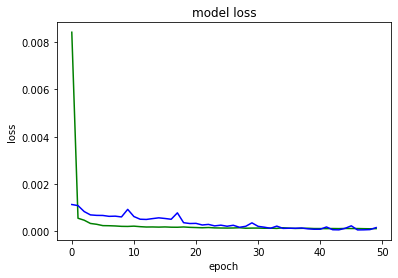

In [ ]:
plt.plot(history.history["loss"],color='green')
plt.plot(history.history["val_loss"],color='blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
js = open("/content/depsepconvlstmmodel.json")
lm = js.read()
js.close()
model1 = tf.keras.models.model_from_json(lm)

In [ ]:
new_model=model1

new_model.load_weights("conv_lstm_sep.h5")

In [ ]:
y_predict_scaled =new_model.predict([test_x,test_x_w,test_x_d])

63/63 [==============================] - 3s 15ms/step


In [ ]:
y_predict_scaled.shape

(2016, 1)

In [ ]:
y_predict=scaler1.inverse_transform(y_predict_scaled )

In [ ]:
test_Y=scaler1.inverse_transform(test_y)

In [ ]:
print(mae(y_predict,test_Y))


1.2195696863863208


In [ ]:
print(sqrt(mse(y_predict,test_Y)))

1.529896227102754


In [ ]:
print(mape(y_predict,test_Y))

0.021938841278372433


#NAS 

In [ ]:
def count_mac_ops(model):
    total_mac_ops = 0
    for layer in model.layers:
        if isinstance(layer, layers.Conv1D):
            mac_ops = layer.kernel_size[0] * layer.output_shape[1] * layer.filters * layer.input_shape[-1]
        elif isinstance(layer, layers.SeparableConv1D):
            mac_ops = layer.kernel_size[0] * layer.output_shape[1] * layer.depth_multiplier * layer.input_shape[-1] + layer.output_shape[1] * layer.filters
        elif isinstance(layer, layers.Conv2D):
            mac_ops = layer.kernel_size[0] * layer.kernel_size[1] * layer.output_shape[1] * layer.output_shape[2] * layer.filters * layer.input_shape[-1]
        elif isinstance(layer, layers.SeparableConv2D):
            mac_ops = (layer.kernel_size[0] * layer.kernel_size[1] * layer.input_shape[-1] * layer.depth_multiplier +
                      layer.output_shape[1] * layer.output_shape[2] * layer.filters)
        elif isinstance(layer, layers.Dense):
            mac_ops = layer.input_shape[-1] * layer.output_shape[-1]
        elif isinstance(layer, layers.LSTM) or isinstance(layer, layers.GRU):
            mac_ops = 4 * (layer.input_shape[-1] * layer.units + layer.units**2)
        elif isinstance(layer, layers.Bidirectional):
            forward_layer = layer.forward_layer
            backward_layer = layer.backward_layer
            forward_mac_ops = 4 * (layer.input_shape[-1] * forward_layer.units + forward_layer.units**2)
            backward_mac_ops = 4 * (layer.input_shape[-1] * backward_layer.units + backward_layer.units**2)
            mac_ops = 2 * (forward_mac_ops + backward_mac_ops)
        else:
            mac_ops = 0
        total_mac_ops += mac_ops
    return total_mac_ops


In [ ]:
count_mac_ops(new_model)

112646

In [ ]:
input1 = Input((n_step,4),name='input1')
input2 = Input((n_step,1),name='input2')
input3 = Input((n_step,1),name='input3')
con1=Conv1D(30,3,strides=1,activation='relu',name='con1')(input1)
# ds1=SeparableConv1D(30,3,strides=1,activation='relu',name='ds1')(input1)
# ds1=DepthwiseConv1D(30,3,strides=1,activation='relu',name='ds1')(input1)
con2=Conv1D(20,3,strides=1,activation='relu',name='con2')(con1)
# ds2=SeparableConv1D(20,3,strides=1,activation='relu',name='ds2')(ds1)
# ds2=DepthwiseConv1D(20,3,strides=1,activation='relu',name='ds2')(ds1)
con_f=Flatten()(con2)
con_out=RepeatVector(1)(con_f)
lstm_out=LSTM(50,activation ="relu",return_sequences=False,name='lstm_out')(con_out)
Bilstm_out1=Bidirectional(LSTM(40,activation ="relu",return_sequences=False))(input2)
Bilstm_out2=Bidirectional(LSTM(40,activation ="relu",return_sequences=False))(input3)
x=Concatenate()([lstm_out,Bilstm_out1,Bilstm_out2])
x1=Dense(20,activation='relu',name='x1')(x)
x2=Dense(10,activation='relu',name='x2')(x1)
output = Dense(1,activation='relu',name='output')(x2)
model2= Model(inputs=[input1,input2,input3],outputs=output)
model2.compile(optimizer="adam", loss = "mse")

In [ ]:
count_mac_ops(model2)

135370

In [ ]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

nas approach

In [ ]:
width_multipliers = [0.2, 0.4, 0.7, 0.8, 0.9, 1.0]
min_depth = 3
max_depth = 9
threshold_mac_ops = 70000  # threshold for the maximum number of MAC operations
target_loss = 0.04 # target validation loss for stopping the model training
fail_loss = 0.04 # validation loss for discarding the model

In [ ]:
feasible_models =[]
for width in width_multipliers:
  for depth in range(3,8):
    input1 = Input((n_step,4),name='input1')
    input2 = Input((n_step,1),name='input2')
    input3 = Input((n_step,1),name='input3')
    x = SeparableConv1D(int(30 * width), 3, strides=1, activation='relu')(input1)
    for i in range(depth - 1):
        x = SeparableConv1D(int(20 * width), 3, strides=1, activation='relu')(x)
    con_f = Flatten()(x)
    con_out = RepeatVector(1)(con_f)
    lstm_out = LSTM(int(50 * width), activation='relu', return_sequences=False)(con_out)
    Bilstm_out1 = Bidirectional(LSTM(int(40 * width), activation='relu', return_sequences=False))(input2)
    Bilstm_out2 = Bidirectional(LSTM(int(40 * width), activation='relu', return_sequences=False))(input3)
    x = Concatenate()([lstm_out, Bilstm_out1, Bilstm_out2])
    x = Dense(int(20 * width), activation='relu')(x)
    x = Dense(int(10 * width), activation='relu')(x)
    output = Dense(1, activation='relu')(x)
    modeln = Model(inputs=[input1,input2,input3],outputs=output)
    modeln.compile(optimizer="adam", loss = "mse")
    maco = count_mac_ops(modeln)
    print(maco)
    if(maco < threshold_mac_ops):
      feasible_models.append(modeln)

4942
4734
4494
4222
3918
17856
16800
15680
14496
13248
52467
48939
45299
41547
37683
68068
63396
58596
53668
48612
85701
79725
73605
67341
60933
105366
97926
90326
82566
74646


In [ ]:
print(len(feasible_models))

22


In [ ]:
best_models=[]
for modeli in feasible_models:
  historyi = modeli.fit([train_x,train_x_w,train_x_d],train_y,epochs=3,validation_split=.15, verbose=1)
  yps = modeli.predict([test_x,test_x_w,test_x_d])
  yp=scaler1.inverse_transform(yps )
  maee = mae(yp,test_Y)
  msee=sqrt(mse(yp,test_Y))
  mapee=mape(yp,test_Y)
  print("mae",maee)
  print("mse",msee)
  print("mape",mapee)
  print("\n")
  if(maee <3.5 and msee<4 and mapee<0.05):
    best_models.append(modeli)

Epoch 1/3
589/589 [==============================] - 19s 33ms/step - loss: 7.1799e-04 - val_loss: 3.8742e-04
Epoch 2/3
589/589 [==============================] - 18s 30ms/step - loss: 6.7876e-04 - val_loss: 8.6519e-04
Epoch 3/3
63/63 [==============================] - 1s 12ms/step
mae 2.718329146740929
mse 3.5490449783418403
mape 0.0516469176569066


Epoch 1/3
589/589 [==============================] - 23s 39ms/step - loss: 0.3760 - val_loss: 0.4217
Epoch 2/3
589/589 [==============================] - 17s 29ms/step - loss: 0.3760 - val_loss: 0.4217
Epoch 3/3
63/63 [==============================] - 1s 10ms/step
mae 86.0639880952381
mse 98.52224841394802
mape 3.875977447157331e+17


Epoch 1/3
589/589 [==============================] - 19s 32ms/step - loss: 9.0630e-04 - val_loss: 0.0010
Epoch 2/3
589/589 [==============================] - 18s 31ms/step - loss: 8.2753e-04 - val_loss: 6.4832e-04
Epoch 3/3
63/63 [==============================] - 1s 12ms/step
mae 3.840338584213031
mse 4.904

In [ ]:
print(len(best_models))

5


In [ ]:
c=0
for modeli in best_models:
  historyi = modeli.fit([train_x,train_x_w,train_x_d],train_y,epochs=50,validation_split=.15, verbose=1)
  yps = modeli.predict([test_x,test_x_w,test_x_d])
  yp=scaler1.inverse_transform(yps )
  maee = mae(yp,test_Y)
  msee=sqrt(mse(yp,test_Y))
  mapee=mape(yp,test_Y)
  print("model :" ,c)
  print("mae",maee)
  print("mse",msee)
  print("mape",mapee)
  print("\n")

  model_json = modeli.to_json()
  with open("depsepconvlstmmodel-"+str(c)+".json", "w") as json_file:
      json_file.write(model_json)
  model.save_weights("conv_lstm_sep-"+str(c)+".h5")

  c+=1

Epoch 1/50
589/589 [==============================] - 26s 44ms/step - loss: 1.2246e-04 - val_loss: 6.2934e-05
Epoch 2/50
589/589 [==============================] - 19s 33ms/step - loss: 1.1750e-04 - val_loss: 1.0383e-04
Epoch 3/50
589/589 [==============================] - 20s 34ms/step - loss: 1.2390e-04 - val_loss: 5.5283e-05
Epoch 4/50
589/589 [==============================] - 19s 33ms/step - loss: 1.2419e-04 - val_loss: 7.4639e-05
Epoch 5/50
589/589 [==============================] - 22s 37ms/step - loss: 1.1461e-04 - val_loss: 4.8604e-05
Epoch 6/50
589/589 [==============================] - 20s 34ms/step - loss: 1.1888e-04 - val_loss: 6.3514e-05
Epoch 7/50
589/589 [==============================] - 19s 32ms/step - loss: 1.1268e-04 - val_loss: 6.6304e-05
Epoch 8/50
589/589 [==============================] - 20s 33ms/step - loss: 1.1210e-04 - val_loss: 5.0974e-05
Epoch 9/50
589/589 [==============================] - 20s 34ms/step - loss: 1.1722e-04 - val_loss: 5.8904e-05
Epoch 10/5

errors of the above models:

model : 0

mae 1.178879781847908

mse 1.4829644867009713

mape 0.020081711278341154


model : 1

mae 0.7788398563861849

mse 1.0234463203982023

mape 0.017086112517337756


model : 2

mae 0.8300397374800275

mse 1.0789250445007141

mape 0.01838390213744286

model : 3

mae 0.7867111615718357

mse 1.0365993741992519

mape 0.01655413182592857

model : 4

mae 1.1190407758667351

mse 1.4049629442056872

mape 0.023854870773506696

In [ ]:
best_models[1].summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 15, 4)]      0           []                               
                                                                                                  
 separable_conv1d_50 (Separable  (None, 13, 21)      117         ['input1[0][0]']                 
 Conv1D)                                                                                          
                                                                                                  
 separable_conv1d_51 (Separable  (None, 11, 14)      371         ['separable_conv1d_50[0][0]']    
 Conv1D)                                                                                          
                                                                                           

In [ ]:
import tensorflow as tf

In [ ]:
# tf lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the model to disk
open("conv_lstm_nasdq_quant.tflite", "wb").write(tflite_model)

140464

In [ ]:
tf_modelq = tf.lite.Interpreter("conv_lstm_nasdq_quant.tflite")
tf_modelq.allocate_tensors()
input_details = tf_modelq.get_input_details()
output_details = tf_modelq.get_output_details()
tf_modelq_predictions = []
input_shape = input_details[0]['shape']
input_shape1 = input_details[1]['shape']
input_shape2 = input_details[2]['shape']
input_data = np.array(test_x, dtype=np.float32)
input_data1 = np.array(test_x_w, dtype=np.float32)
input_data2 = np.array(test_x_d, dtype=np.float32)
tf_model_output_index = output_details[0]['index']
for i in range(len(test_x)):
    tf_modelq.set_tensor(input_details[0]['index'], input_data2[i].reshape(1,input_data2.shape[1],1))
    tf_modelq.set_tensor(input_details[1]['index'], input_data[i].reshape(1,input_data.shape[1],input_data.shape[2]))
    tf_modelq.set_tensor(input_details[2]['index'], input_data1[i].reshape(1,input_data1.shape[1],1))
    tf_modelq.invoke()
    x1=tf_modelq.get_tensor(tf_model_output_index)
    tf_modelq_predictions.append(x1[0])

In [ ]:
tf_pred=scaler1.inverse_transform(tf_modelq_predictions)

In [ ]:

print(mae(tf_pred,test_Y))

1.9674679904433328


In [ ]:
print(sqrt(mse(tf_pred,test_Y)))

2.427730179966212


In [ ]:
print(mape(tf_pred,test_Y))

0.03735375076066441
